In [55]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, TensorDataset

In [56]:
df = pd.read_csv("creditcard.csv", low_memory=False)
X = df.iloc[:, :-1]
y = df['Class']

In [57]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [58]:
frauds = df.loc[df["Class"] == 1]
legit = df.loc[df["Class"] == 0]

print(f"There is {len(frauds)} frauds and {len(legit)} legits transactions")

There is 492 frauds and 284315 legits transactions


In [59]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

X_rescaled = scale(X_resampled)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_rescaled)

print(f"Data shape after PCA: {X_pca.shape}")

Data shape after PCA: (568630, 10)


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_resampled, test_size=0.3, random_state=42)
print(f"Dataset len: {X_train.shape}")

Dataset len: (398041, 10)


In [87]:
# Configure the device to use GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
batch_size = 64
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                           torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device),
                          torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [91]:
# Network

class MainNetwork(nn.Module):
    def __init__(self):
        super(MainNetwork, self).__init__()
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 27)
        self.fc3 = nn.Linear(27, 16)
        self.fc4 = nn.Linear(16, 2)
        self.fc5 = nn.Linear(2, 1)

        self.tahn = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.tahn(self.fc1(x))
        x = self.tahn(self.fc2(x))
        x = self.tahn(self.fc3(x))
        x = self.tahn(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

In [92]:
model = MainNetwork().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



In [94]:
epochs = 120
for epoch in range(epochs):
    model.train()  
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        y_pred = model(inputs)

        loss = criterion(y_pred, labels)

        loss.backward()

        optimizer.step()

        predicted = (y_pred > 0.5).float()
        correct = (predicted == labels).float()
        acc = correct.sum() / len(correct)

      
        running_loss += loss.item()
        running_accuracy += acc.item()

   
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = running_accuracy / len(train_loader)

    print(f'Epoch [{
          epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy * 100:.2f}%')

Epoch [1/120], Loss: 0.0606, Accuracy: 97.80%
Epoch [2/120], Loss: 0.0601, Accuracy: 97.81%
Epoch [3/120], Loss: 0.0595, Accuracy: 97.83%
Epoch [4/120], Loss: 0.0589, Accuracy: 97.84%
Epoch [5/120], Loss: 0.0583, Accuracy: 97.86%
Epoch [6/120], Loss: 0.0578, Accuracy: 97.88%
Epoch [7/120], Loss: 0.0571, Accuracy: 97.91%
Epoch [8/120], Loss: 0.0565, Accuracy: 97.90%
Epoch [9/120], Loss: 0.0560, Accuracy: 97.94%
Epoch [10/120], Loss: 0.0555, Accuracy: 97.96%
Epoch [11/120], Loss: 0.0549, Accuracy: 97.96%
Epoch [12/120], Loss: 0.0542, Accuracy: 97.99%
Epoch [13/120], Loss: 0.0537, Accuracy: 98.01%
Epoch [14/120], Loss: 0.0530, Accuracy: 98.02%
Epoch [15/120], Loss: 0.0524, Accuracy: 98.05%
Epoch [16/120], Loss: 0.0518, Accuracy: 98.07%
Epoch [17/120], Loss: 0.0512, Accuracy: 98.10%
Epoch [18/120], Loss: 0.0506, Accuracy: 98.11%
Epoch [19/120], Loss: 0.0500, Accuracy: 98.12%
Epoch [20/120], Loss: 0.0494, Accuracy: 98.16%
Epoch [21/120], Loss: 0.0488, Accuracy: 98.18%
Epoch [22/120], Loss: 

In [96]:
model.eval()

with torch.no_grad():
    test_loss = 0.0
    test_accuracy = 0.0
    y_pred_test = []
    y_true_test = []

    for inputs, labels in test_loader:
       
        inputs, labels = inputs.to(device), labels.to(device)

        y_pred = model(inputs)

        loss = criterion(y_pred, labels)
        test_loss += loss.item()

      
        predicted = (y_pred > 0.5).float()

        correct = (predicted == labels).float()
        acc = correct.sum() / len(correct)
        test_accuracy += acc.item()

        y_pred_test.extend(predicted.cpu().numpy())
        y_true_test.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    avg_test_accuracy = test_accuracy / len(test_loader)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {
          avg_test_accuracy * 100:.2f}%")

Test Loss: 0.0245, Test Accuracy: 99.23%


In [97]:
y_pred_test = np.array(y_pred_test).flatten()
y_true_test = np.array(y_true_test).flatten()

In [98]:
false_neg = np.sum((y_pred_test == 0) & (y_true_test == 1))  
false_pos = np.sum((y_pred_test == 1) & (y_true_test == 0))  
incorrect = np.sum(y_pred_test != y_true_test)  
total = len(y_true_test)  

accuracy = accuracy_score(y_true_test, y_pred_test)
inaccuracy = incorrect / total

# Exibindo as métricas
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Incorrect: {inaccuracy * 100:.2f}%')
print(f'False negatives: {false_neg / incorrect:.2f}')
print(f'False positives: {false_pos / incorrect:.2f}')
print(f'False negatives/total: {false_neg / total:.2f}')

Accuracy: 99.23%
Incorrect: 0.77%
False negatives: 0.34
False positives: 0.66
False negatives/total: 0.00


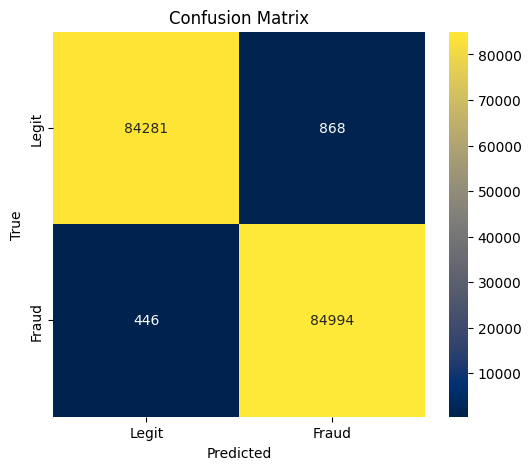

In [103]:
cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', xticklabels=[
            'Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [100]:
torch.save(model.state_dict(), 'model_weights.pth')